In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

#  Load ECG Dataset

Dataset Original Length n:  3000
Dataset Sampled Length n:  3000
../datasets/ground_truth/ecg-heartbeat-av_gt.csv


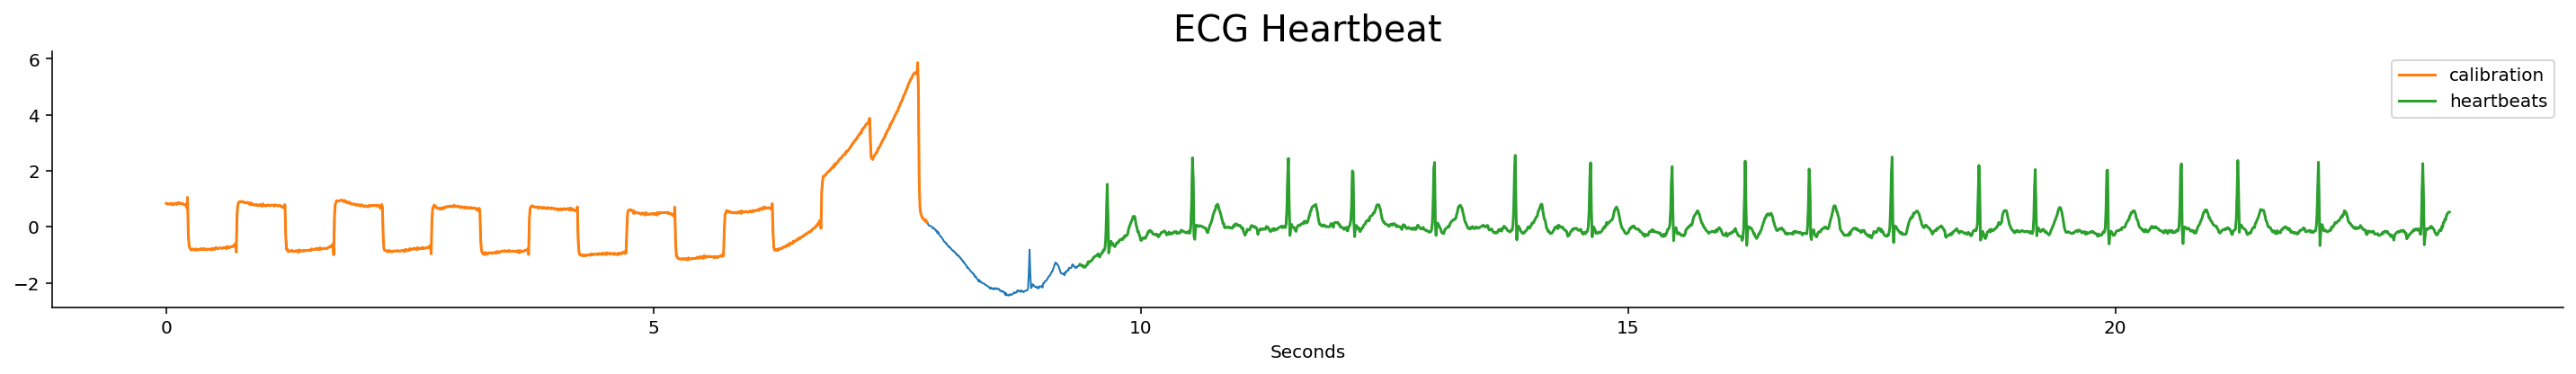

In [2]:
ds_name = "ECG Heartbeat"
file = 'ecg-heartbeat-av.csv'
series, df_gt = ml.read_dataset_with_index(file)
data = series.values
#series = ml.as_series(data, np.arange(0, 3000, 1) / 128, 'Seconds')
plot_dataset(file, series, ds_name=ds_name, ground_truth=df_gt)

# Parameters

In [3]:
df = pd.DataFrame() # TOP-1
df2 = pd.DataFrame() # TOP-2

rerun_all_jars = False
ks=20
dataset = os.getcwd() + '/../datasets/original/' + file
print(dataset)

/Users/bzcschae/workspace/motiflets_paper/notebooks/../datasets/ecg-heartbeat-av.csv


# k-Motiflets

## First, we learn the motif length l

Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.47it/s]


Motif Length: 12 	 0.09375 	AU_PEF: 0.361 	#Elbows: 5


Compute ks: 100%|█████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.22it/s]


Motif Length: 25 	 0.1953125 	AU_PEF: 0.4 	#Elbows: 5


Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:00<00:00, 86.89it/s]


Motif Length: 37 	 0.2890625 	AU_PEF: 0.36 	#Elbows: 5


Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:00<00:00, 74.64it/s]


Motif Length: 50 	 0.390625 	AU_PEF: 0.279 	#Elbows: 5


Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:00<00:00, 73.67it/s]


Motif Length: 62 	 0.484375 	AU_PEF: 0.267 	#Elbows: 4


Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:00<00:00, 62.98it/s]


Motif Length: 75 	 0.5859375 	AU_PEF: 0.375 	#Elbows: 4


Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:00<00:00, 51.23it/s]


Motif Length: 87 	 0.6796875 	AU_PEF: 0.462 	#Elbows: 4


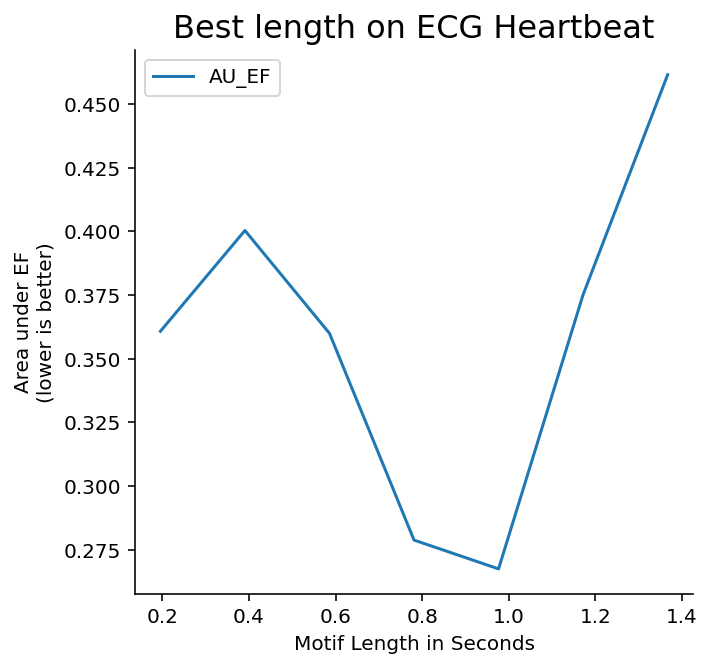

Found motif length 125


In [4]:
length_range = np.arange(25,200,25) 
motif_length = plot_motif_length_selection(
    ks, series, file, 
    motif_length_range=length_range, ds_name=ds_name)

print ("Found motif length", motif_length)

## Next, we learn the size k of the motif set

Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:01<00:00, 14.21it/s]


Chosen window-size: 125
Identified Elbow Points [ 6  9 16]
Filtered Elbow Points [6, 16]


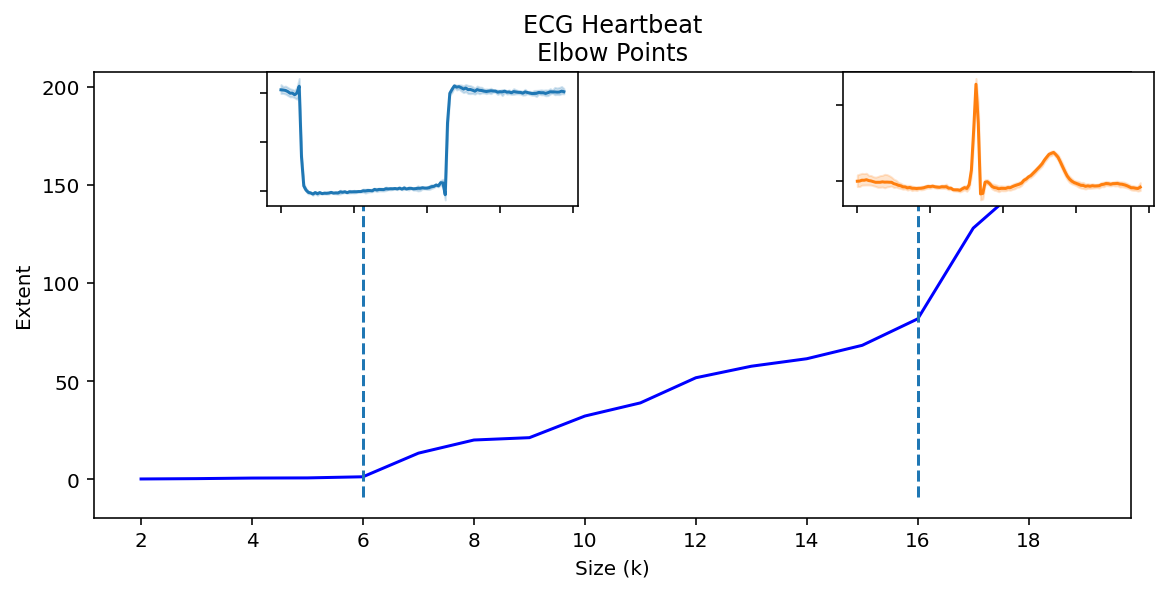

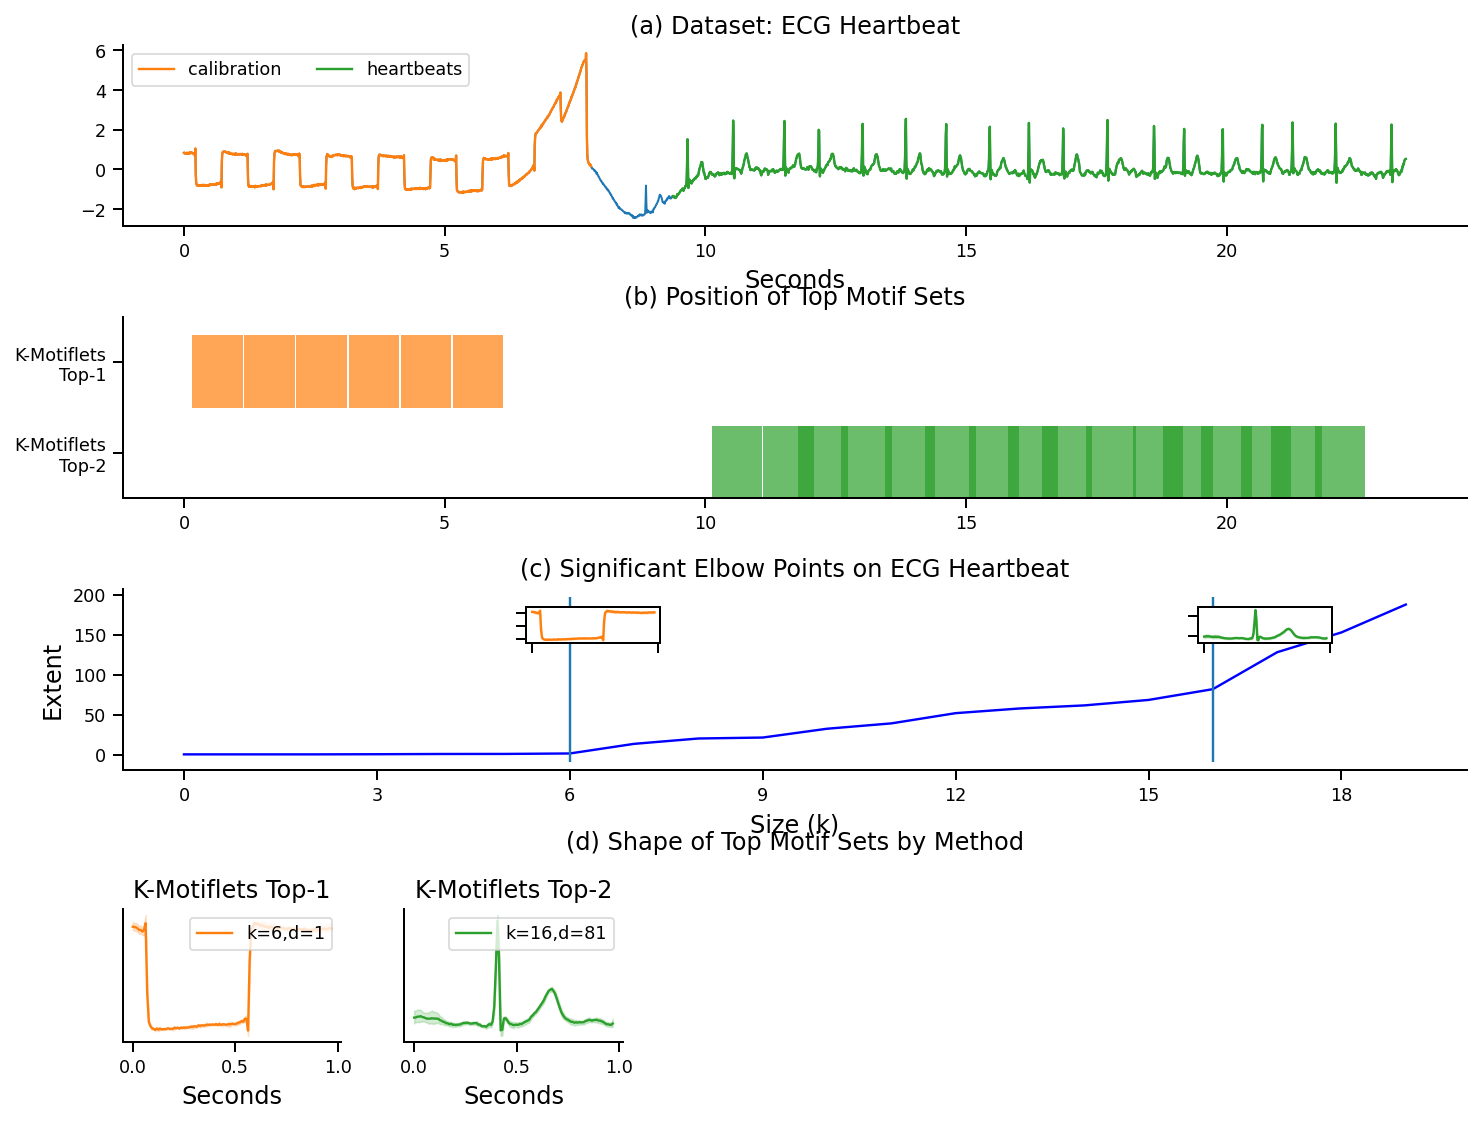

In [5]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, file, ds_name=ds_name, plot_elbows=True,
    motif_length=motif_length, method_name="K-Motiflets", ground_truth=df_gt)

In [6]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]
r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-2]])
print("Radius r of TOP-2 Motifs", r_top1, r_top2)
print("Extent d of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

Radius r of TOP-2 Motifs 55.67435836791992 0.8364326357841492
Extent d of TOP-1 Motif 81.79418182373047


# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error.

We pretend to have an oracle on the length l and the radius r. But sometimes this oracle is off by just 10% on both parameters to reflect human trial-and-error.

In [7]:
radii = np.array([r_top2, r_top1])
print("Radii r", radii)

print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

# Human error due to trial-and-error
errors = [0, -0.10, 0.10]

Radii r [ 0.83643264 55.67435837]
Best Radii	 [ 0.83643264 55.67435837]
Best Lengths	 125


# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [8]:
rs = np.array([r_top2*10, r_top1*1.5])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/set_finder.jar',
           dataset,
           'SetFinder',
           str(list(rs)),
           str(mls)])

,offsets
SF Top-1,"[1421, 1295, 1506, 1612, 1718, 1817, 1924, 202..."
SF Top-1 -10%,"[1410, 1284, 1495, 1601, 1707, 1807, 1913, 201..."
SF Top-1 +10%,"[1207, 163, 291, 419, 547, 676, 803, 859, 1100..."
SF Top-2,"[671, 158, 286, 414, 542, 798]"
SF Top-2 -10%,"[406, 150, 278, 534, 662]"
SF Top-2 +10%,"[671, 158, 286, 414, 542, 798]"


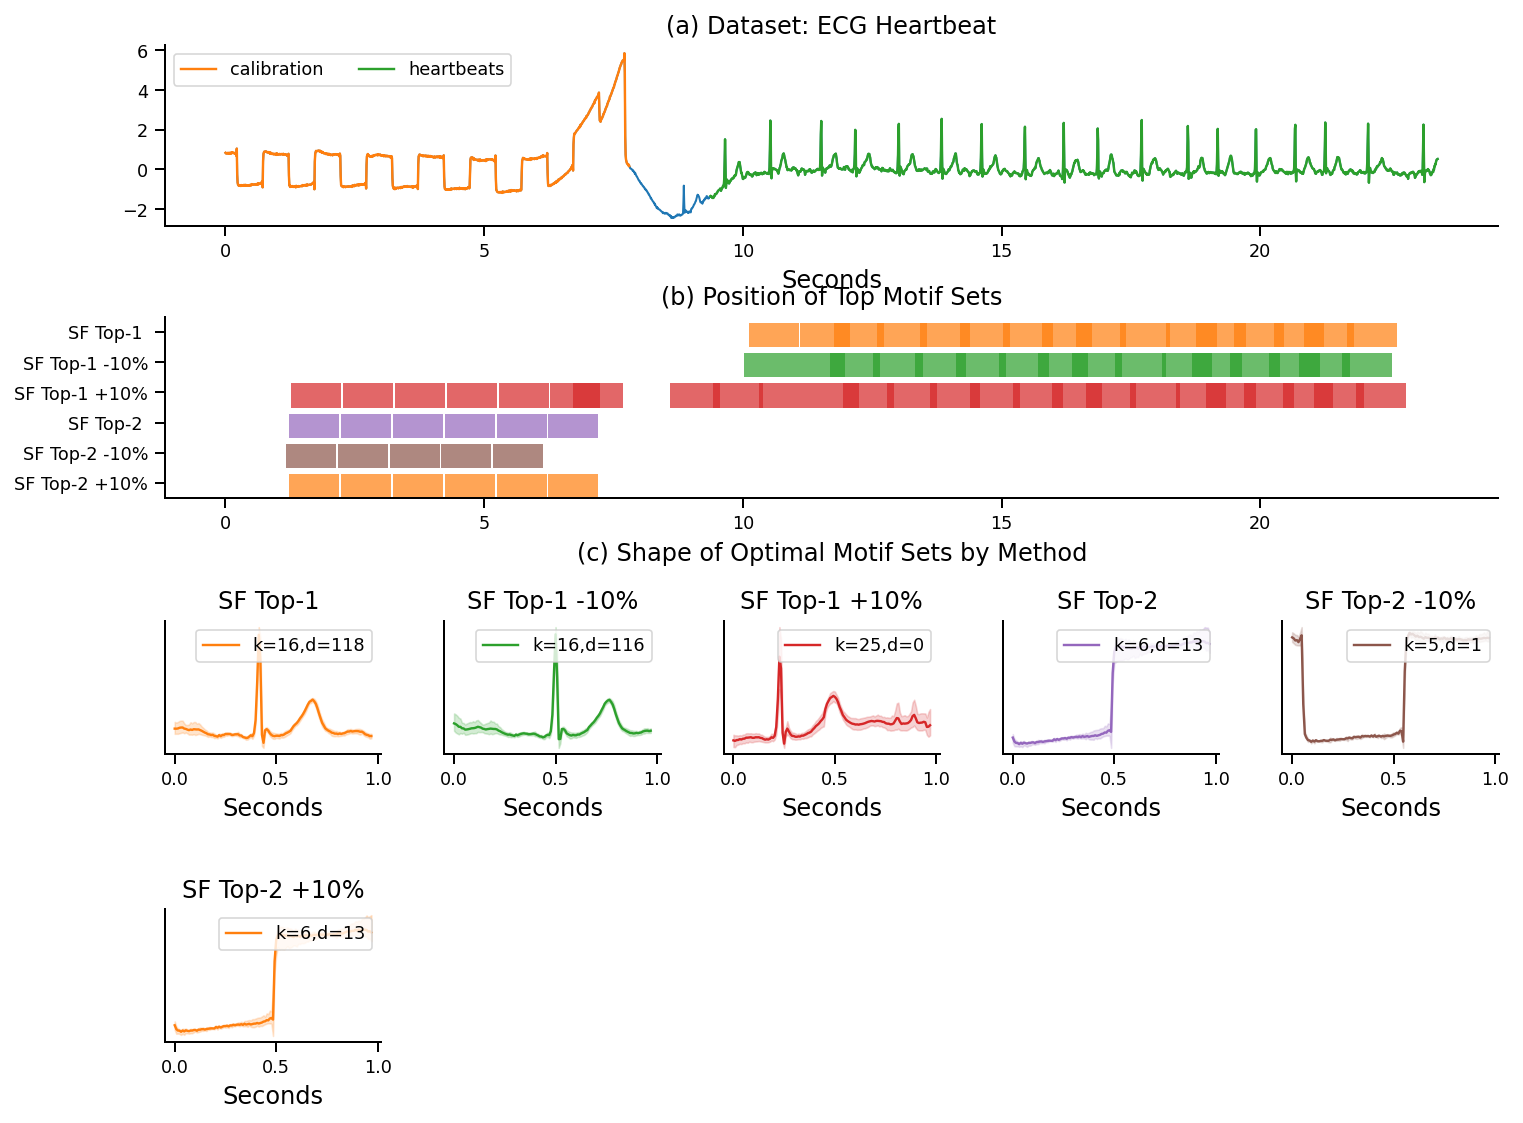

In [9]:
# run jave code first       
ms_all = {
    "" : [
    [671, 158, 286, 414, 542, 798],
	[1421, 1295, 1506, 1612, 1718, 1817, 1924, 2021, 2105, 2213, 2328, 2402, 2496, 2593, 2668, 2774],
    ], 
    "-10%" :[
    [406, 150, 278, 534, 662],
	[1410, 1284, 1495, 1601, 1707, 1807, 1913, 2010, 2094, 2202, 2317, 2391, 2486, 2583, 2657, 2763],
    ],   
    "+10%" :[
    [671, 158, 286, 414, 542, 798],
	[1207, 163, 291, 419, 547, 676, 803, 859, 1100, 1319, 1444, 1529, 1636, 1742, 1841, 1948, 2045, 2129, 2237, 2352, 2426, 2520, 2617, 2692, 2798],
    ]
}


df_all_1  = pd.DataFrame()
df_all_2  = pd.DataFrame()
for key in ms_all:       
    ms_set_finder = ms_all[key]
    df_all_1["SF Top-1 " + key] = [ms_set_finder[-1]]
    df_all_2["SF Top-2 " + key] = [ms_set_finder[-2]]

    df["SF Top-1 " + key] = [ms_set_finder[-1]]
    df2["SF Top-2 " + key] = [ms_set_finder[-2]]

    
df_all = (pd.concat([df_all_1, df_all_2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
display(df_all)
motifsets = df_all["offsets"].to_numpy()
plot_all_competitors(series, ds_name, motifsets, motif_length,
                     method_names=df_all.index.values, ground_truth=df_gt)

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [10]:
rs = np.array([r_top2*10, r_top1*2.92])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/emma.jar',
           dataset,
           str(list(rs)),
           str(mls)])

,offsets
EMMA Top-1,"[19, 146, 275, 403, 532, 779, 841, 1067, 1129,..."
EMMA Top-1 -10%,"[13, 140, 269, 397, 526, 770, 838, 1061, 1129,..."
EMMA Top-1 +10%,"[0, 124, 253, 381, 509, 637, 854, 1047, 1103, ..."
EMMA Top-2,"[30, 158, 286, 414, 542, 798]"
EMMA Top-2 -10%,"[139, 267, 395, 523, 651]"
EMMA Top-2 +10%,"[30, 158, 286, 414, 542, 799]"


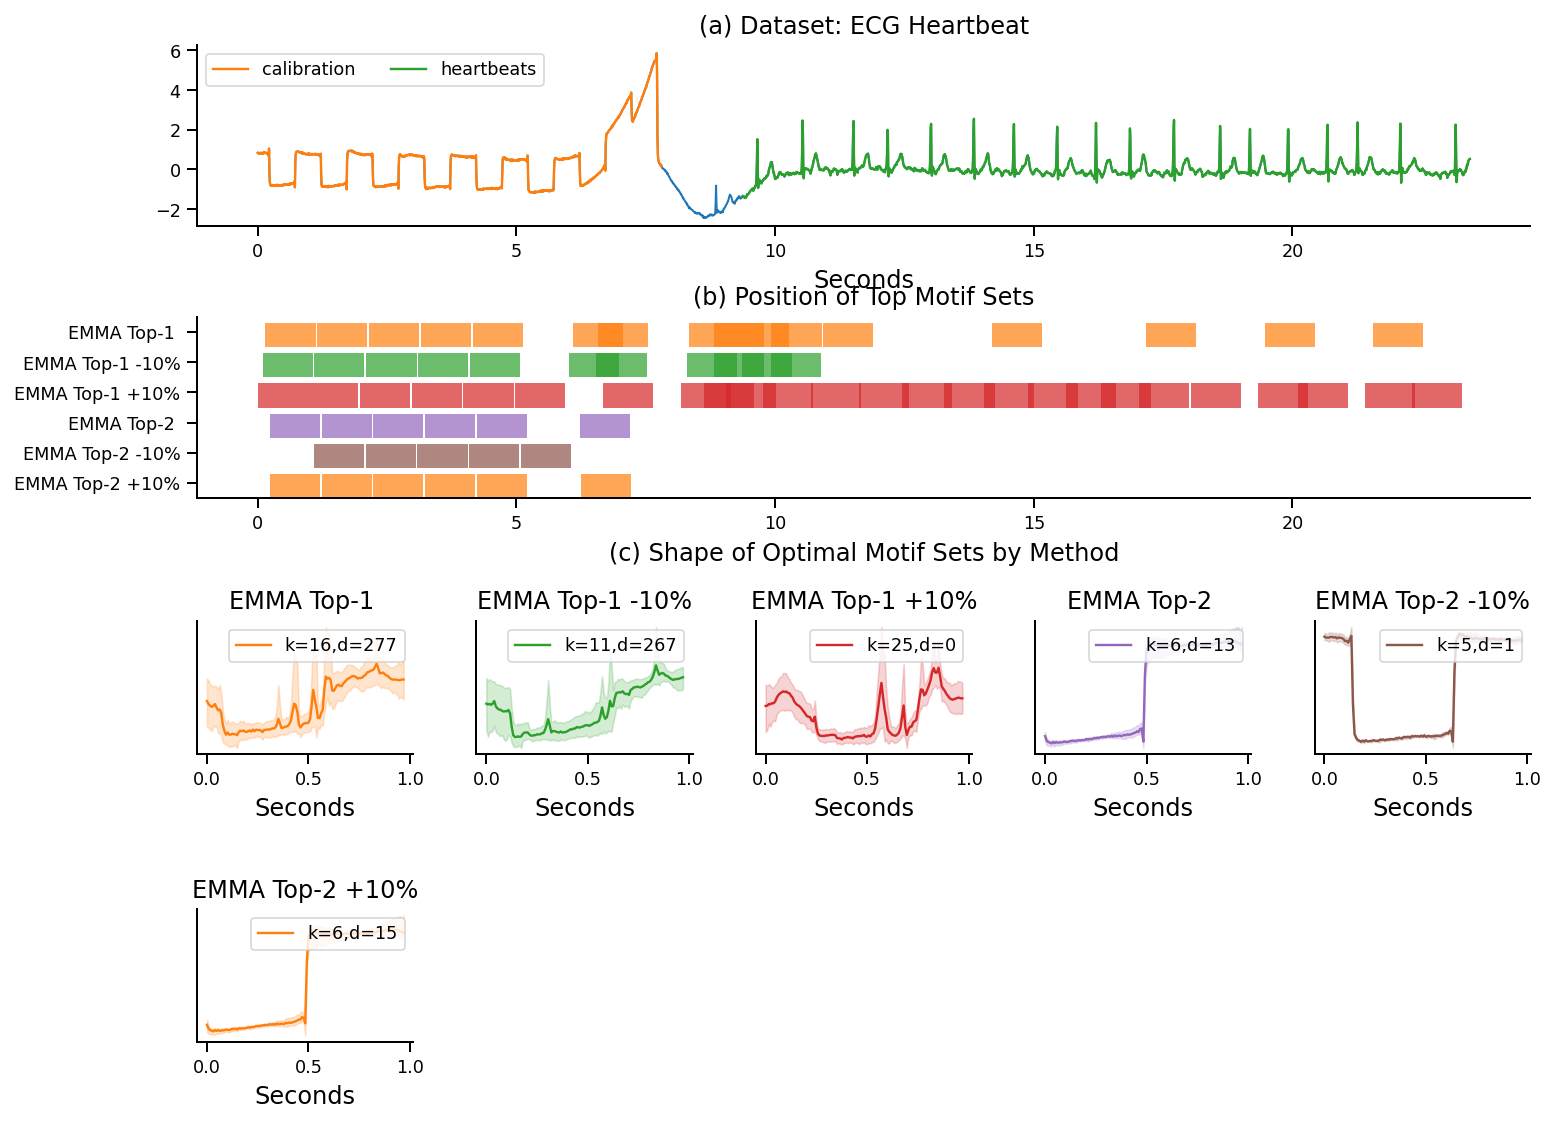

In [11]:
# run jave code first       
ms_all = {
    "" : [
    [30, 158, 286, 414, 542, 798],
	[19, 146, 275, 403, 532, 779, 841, 1067, 1129, 1191, 1271, 1399, 1816, 2198, 2493, 2760],
    ], 
    "-10%" :[
    [139, 267, 395, 523, 651],
	[13, 140, 269, 397, 526, 770, 838, 1061, 1129, 1197, 1270],
    ],
    "+10%" :[
    [30, 158, 286, 414, 542, 799],
	[0, 124, 253, 381, 509, 637, 854, 1047, 1103, 1159, 1250, 1368, 1488, 1593, 1699, 1796, 1905, 1999, 2087, 2180, 2308, 2474, 2573, 2740, 2855],    ]    
}

df_all_1  = pd.DataFrame()
df_all_2  = pd.DataFrame()
for key in ms_all:       
    ms_learning_motifs = ms_all[key]
    df_all_1["EMMA Top-1 " + key] = [ms_learning_motifs[-1]]
    df_all_2["EMMA Top-2 " + key] = [ms_learning_motifs[-2]]

    df["EMMA Top-1 " + key] = [ms_learning_motifs[-1]]
    df2["EMMA Top-2 " + key] = [ms_learning_motifs[-2]]

    
df_all = (pd.concat([df_all_1, df_all_2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
display(df_all)

motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length,
                     method_names=df_all.index.values, ground_truth=df_gt)

# Valmod Motif Sets
based on own (fixed-length) implementation

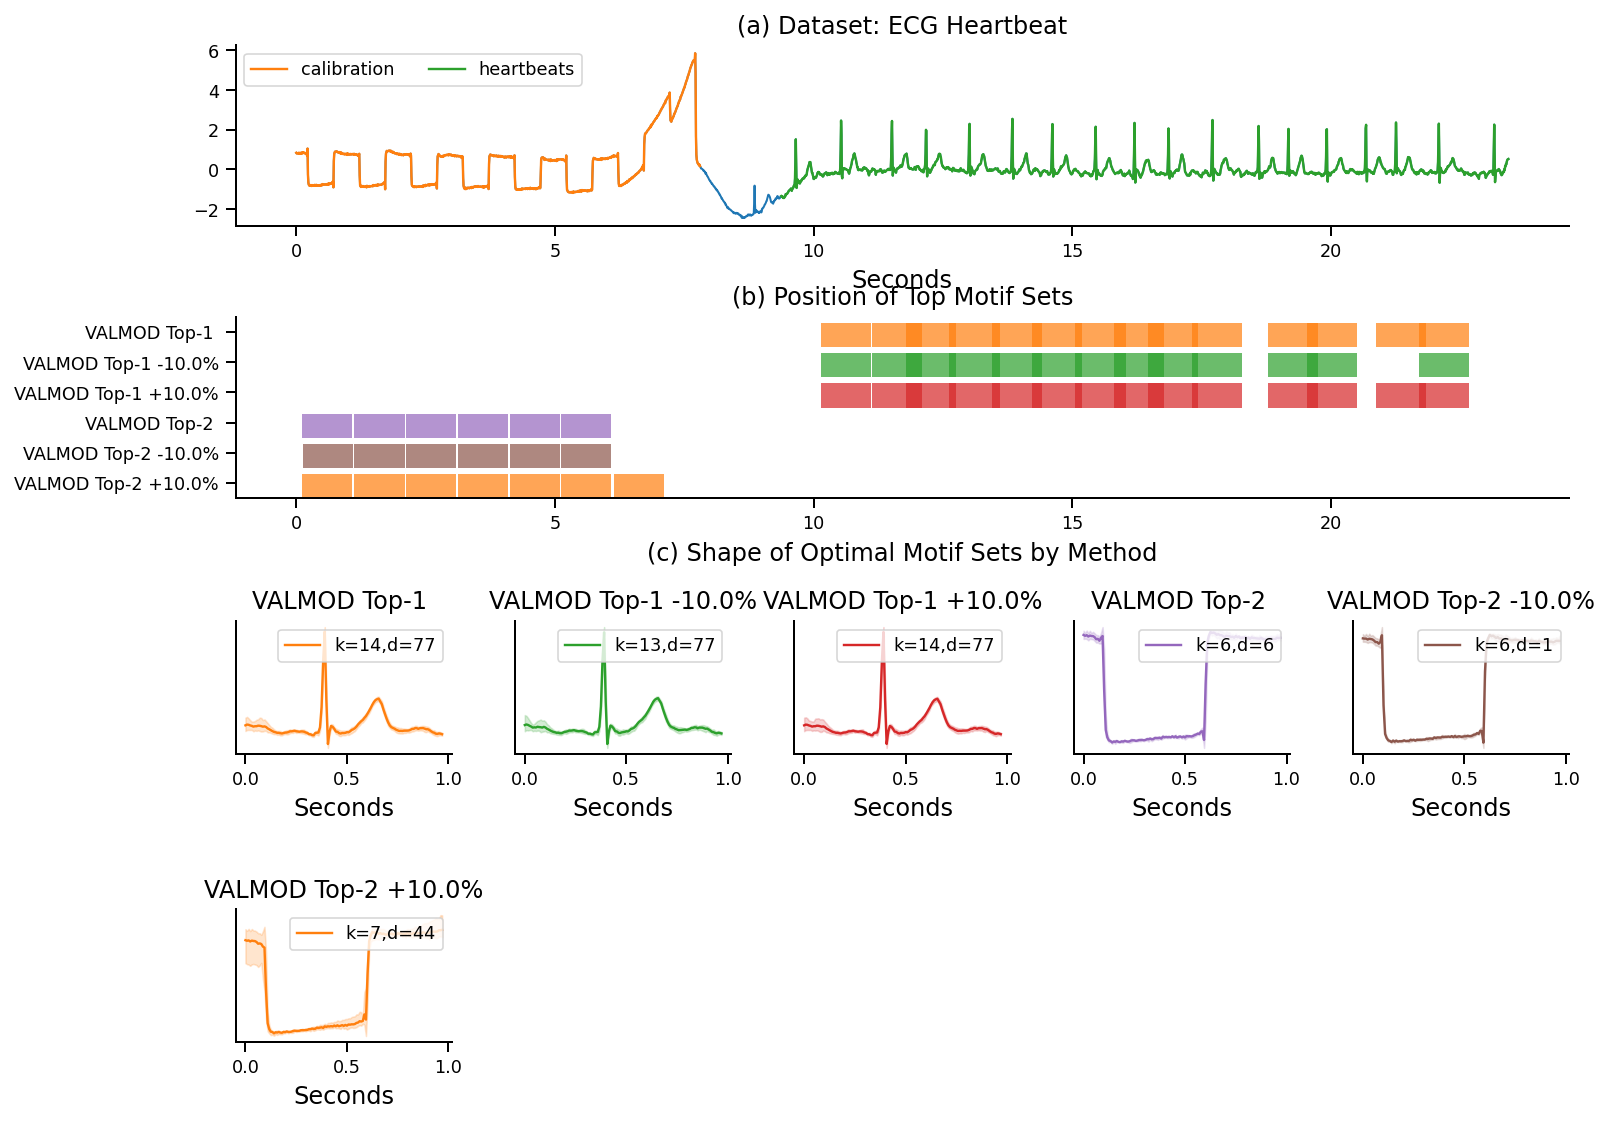

In [12]:
mls = motif_length
max_r=r_top1 * 4.0

df_all_1  = pd.DataFrame()
df_all_2  = pd.DataFrame()

for e in errors:
    rs = max_r * (1.0 * (1+e))
    #mls = np.int32(motif_length * (1-e))
    ms_valmod = list(get_valmod_motif_set_ranged(data, file, mls, max_r=rs))    
    key = format_key(e)
    df_all_1["VALMOD Top-1 " + key ] = [ms_valmod[-1]]
    df_all_2["VALMOD Top-2 " + key ] = [ms_valmod[-2]]

    df["VALMOD Top-1 " + key ] = [ms_valmod[-1]]
    df2["VALMOD Top-2 " + key] = [ms_valmod[-2]]


df_all = (pd.concat([df_all_1, df_all_2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)

motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length,
                     method_names=df_all.index.values, ground_truth=df_gt)

# Learning Motifs
See Java Code

In [13]:
rs = np.array([r_top2+8, r_top1*1.])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/latent_motifs.jar',
           dataset,
           str(list(rs)),
           str(mls)])

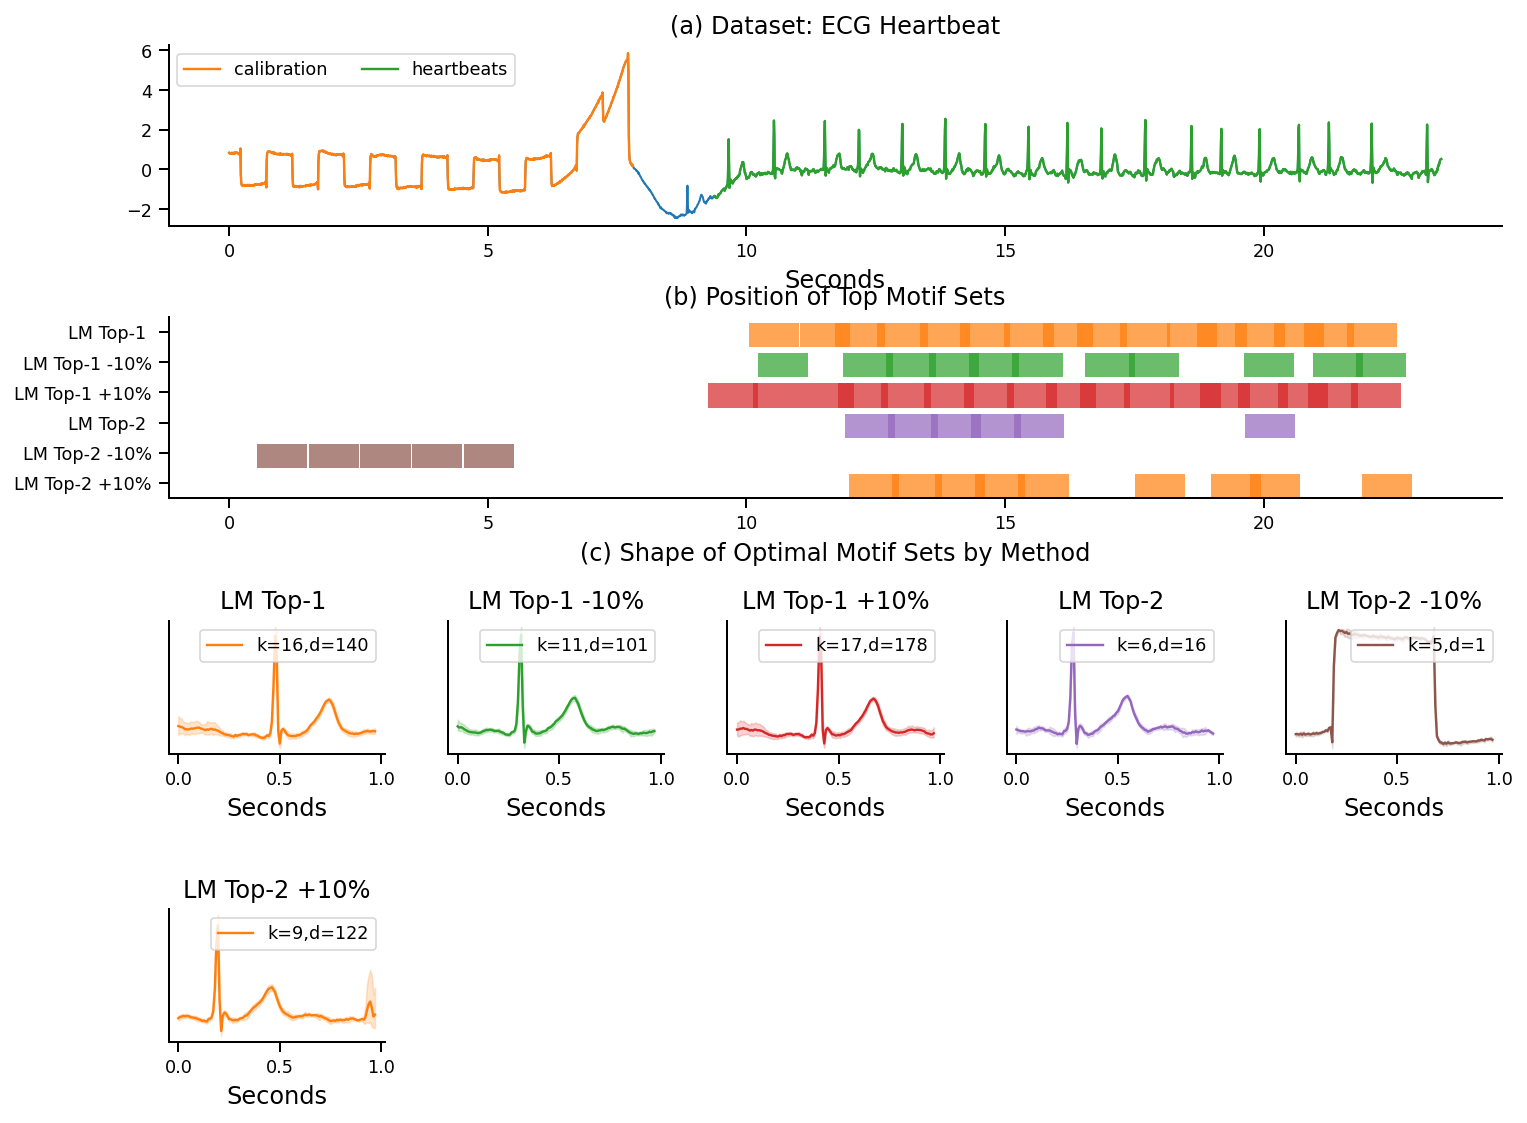

In [14]:
ms_all = {
    "" : [
        [1523,1630,1736,1835,1942,2514,],
        [1287,1412,1498,1604,1710,1809,1916,2013,2097,2205,2320,2394,2488,2585,2660,2766],
    ], 
    "-10%" : [    
        [69,197,325,453,581,],
        [1308,1519,1626,1732,1831,1938,2118,2227,2510,2682,2787,],
    ],        
    "+10%" : [
        [1534,1641,1747,1846,1953,2242,2430,2525,2802,],
        [1184,1296,1421,1506,1613,1719,1818,1925,2022,2106,2214,2329,2403,2497,2594,2669,2775,],
    ],
}



# run jave code first       
df_all_1  = pd.DataFrame()
df_all_2  = pd.DataFrame()
for key in ms_all:       
    ms_learning_motifs = ms_all[key]
    df_all_1["LM Top-1 " + key] = [ms_learning_motifs[-1]]
    df_all_2["LM Top-2 " + key] = [ms_learning_motifs[-2]]

    df["LM Top-1 " + key] = [ms_learning_motifs[-1]]
    df2["LM Top-2 " + key] = [ms_learning_motifs[-2]]


    
df_all = (pd.concat([df_all_1, df_all_2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
df_all


motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     method_names=df_all.index.values, ground_truth=df_gt)

# Comparison

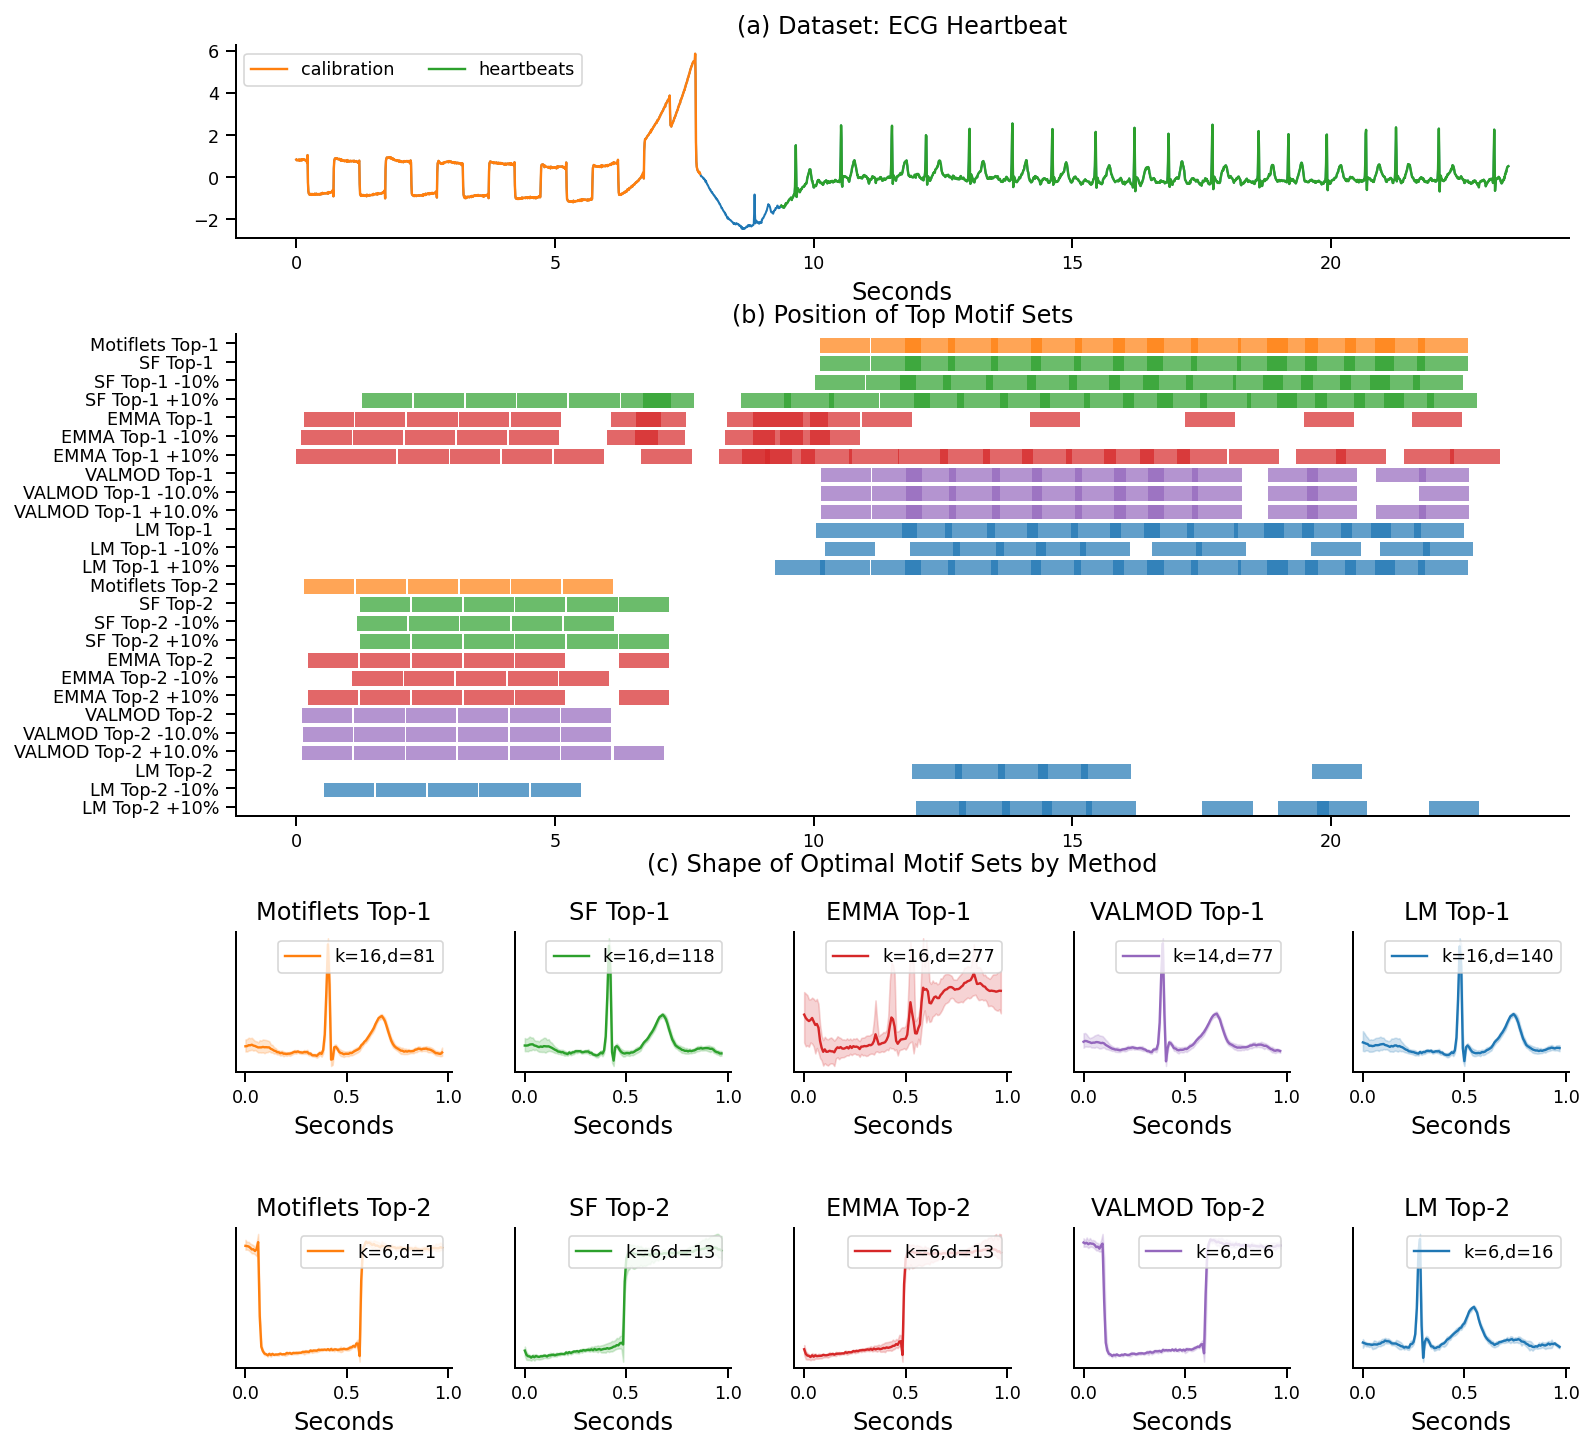

In [15]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)

index = np.array([0, 1, 2, 3, 4])
color_palette=np.array(sns.color_palette())[index]
plot_index=[0, 1, 4, 7, 10, 13, 14, 17, 20, 23]

motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, color_palette=color_palette,
                     method_names=df_all.index.values, ground_truth=df_gt, plot_index=plot_index)            